In [ ]:
# !pip install  rioxarray
# !pip install geopandas

In [ ]:
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon
import shapely.wkt



In [ ]:
# # importando api earth engine
# import ee
# # autorização com login 
# ee.Authenticate()
# # iniciando a biblioteca
# ee.Initialize()

In [ ]:
#  CONECTANDO AO GOOGLE DRIVE
from google.colab import drive

drive.mount('/content/drive')

url = '/content/drive/MyDrive/mapbiomas-ar'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_name = url + '/OCO2GriddedXCO2_20170709_v2_1605546720.nc'
nc_file = xr.open_dataset(file_name)
nc_file

/usr/local/lib/python3.7/dist-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:                 (epoch_dimension: 7, levels: 20, time: 4130)
Coordinates:
  * time                    (time) datetime64[ns] 2017-07-09T23:06:02.0719997...
  * levels                  (levels) int16 1 2 3 4 5 6 7 ... 15 16 17 18 19 20
Dimensions without coordinates: epoch_dimension
Data variables: (12/14)
    latitude                (time) float32 ...
    longitude               (time) float32 ...
    xco2                    (time) float32 ...
    xco2_apriori            (time) float32 ...
    xco2_uncertainty        (time) float32 ...
    pressure_levels         (time, levels) float32 ...
    ...                      ...
    pressure_weight         (time, levels) float32 ...
    source_data_mode        (time) float32 ...
    date                    (time, epoch_dimension) float32 ...
    decorrelation_distance  (time) float64 ...
    land_inflation_factor   float64 ...
    ocean_inflation_factor  float64 ...
Attributes: (12/15)
    title:                          OCO-2 Gridded Level 4 bias-corrected XCO2...
    VersionID:                      2
    OCO2DataVersion:                v10
    ShortName:                      OCO2GriddedXCO2
    RangeBeginningDate:             2017-07-09
    RangeBeginningTime:             01:07:45.694921
    ...                             ...
    IdentifierProductDOI:           10.5067/7KURDO0SQE1R
    IdentifierProductDOIAuthority:  http://dx.doi.org/
    GranuleID:                      OCO2GriddedXCO2_20170709_v2_1605546720.nc
    Format:                         netCDF
    ProcessingLevel:                4
    Conventions:                    CF-1.7

In [ ]:
xco2 = nc_file[[
    'longitude',
    'latitude',
    'xco2'
]]
xco2 = xco2.to_dataframe()

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(xco2['longitude'], xco2['latitude'])]

points = gpd.GeoDataFrame(xco2, 
                          crs = crs, 
                          geometry = geometry)


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
points

,longitude,latitude,xco2,geometry
time,,,,
2017-07-09 23:06:02.071999744,-170.5,66.5,403.254456,POINT (-170.50000 66.50000)
2017-07-09 23:06:02.085169920,-169.5,66.5,403.268433,POINT (-169.50000 66.50000)
2017-07-09 23:06:01.950051840,-167.5,65.5,403.267242,POINT (-167.50000 65.50000)
2017-07-09 23:06:01.876265728,-166.5,65.5,403.268433,POINT (-166.50000 65.50000)
2017-07-09 23:05:59.330804224,-166.5,66.5,403.432800,POINT (-166.50000 66.50000)
...,...,...,...,...
2017-07-09 01:25:18.069811200,179.5,17.5,406.309357,POINT (179.50000 17.50000)
2017-07-09 01:25:34.445809920,179.5,18.5,406.322083,POINT (179.50000 18.50000)
2017-07-09 01:25:54.727772416,179.5,19.5,406.367462,POINT (179.50000 19.50000)


In [ ]:
buffers = points.buffer(0.5)
bounds = buffers.bounds

bounds['pixel_area'] = bounds.apply(
  lambda obj: Polygon(shell=[
    Point(obj['maxx'],obj['miny']),
    Point(obj['minx'],obj['miny']),
    Point(obj['minx'],obj['maxy']),
    Point(obj['maxx'],obj['maxy']),
    Point(obj['maxx'],obj['miny']),
  ]),
  axis=1
)



merge = bounds.merge(points, on='time')
merge

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


,minx,miny,maxx,maxy,pixel_area,longitude,latitude,xco2,geometry
time,,,,,,,,,
2017-07-09 23:06:02.071999744,-171.0,66.0,-170.0,67.0,"POLYGON ((-170 66, -171 66, -171 67, -170 67, ...",-170.5,66.5,403.254456,POINT (-170.50000 66.50000)
2017-07-09 23:06:02.085169920,-170.0,66.0,-169.0,67.0,"POLYGON ((-169 66, -170 66, -170 67, -169 67, ...",-169.5,66.5,403.268433,POINT (-169.50000 66.50000)
2017-07-09 23:06:01.950051840,-168.0,65.0,-167.0,66.0,"POLYGON ((-167 65, -168 65, -168 66, -167 66, ...",-167.5,65.5,403.267242,POINT (-167.50000 65.50000)
2017-07-09 23:06:01.876265728,-167.0,65.0,-166.0,66.0,"POLYGON ((-166 65, -167 65, -167 66, -166 66, ...",-166.5,65.5,403.268433,POINT (-166.50000 65.50000)
2017-07-09 23:05:59.330804224,-167.0,66.0,-166.0,67.0,"POLYGON ((-166 66, -167 66, -167 67, -166 67, ...",-166.5,66.5,403.432800,POINT (-166.50000 66.50000)
...,...,...,...,...,...,...,...,...,...
2017-07-09 01:25:18.069811200,179.0,17.0,180.0,18.0,"POLYGON ((180 17, 179 17, 179 18, 180 18, 180 ...",179.5,17.5,406.309357,POINT (179.50000 17.50000)
2017-07-09 01:25:34.445809920,179.0,18.0,180.0,19.0,"POLYGON ((180 18, 179 18, 179 19, 180 19, 180 ...",179.5,18.5,406.322083,POINT (179.50000 18.50000)
2017-07-09 01:25:54.727772416,179.0,19.0,180.0,20.0,"POLYGON ((180 19, 179 19, 179 20, 180 20, 180 ...",179.5,19.5,406.367462,POINT (179.50000 19.50000)


In [ ]:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(18, 7))


ax.set_xlim(174.0, 181.0)
ax.set_ylim(25.0, 7.0)
world.plot(ax=ax, alpha=0.4, color='grey')


gpd.GeoDataFrame(
  merge,
  crs = crs, 
  geometry = [a for a in merge['pixel_area']]                                
  ).plot(column='xco2', ax=ax, legend=True)

plt.title('xco2 from GoSat L4')

Text(0.5, 1.0, 'xco2 from GoSat L4')

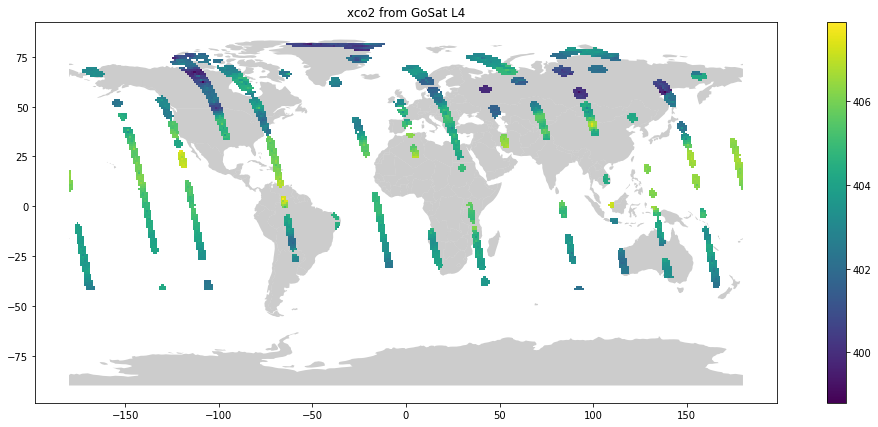

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(18, 7))


# ax.set_xlim(178.0, 181.0)
# ax.set_ylim(20.0, 23.0)
world.plot(ax=ax, alpha=0.4, color='grey')

gpd.GeoDataFrame(
  merge,
  crs = crs, 
  geometry = [a for a in merge['pixel_area']]                                
  ).plot(column='xco2', ax=ax, legend=True)

# gpd.GeoDataFrame(
#   points,
#   crs = crs, 
#   geometry = [a for a in points['geometry']]                                
#   ).plot(column='xco2', ax=ax)



plt.title('xco2 from GoSat L4')


In [ ]:

gdf = merge.copy()
gdf = gpd.GeoDataFrame(
  gdf,
  crs = crs, 
  geometry = [a for a in gdf['pixel_area']]                               
  )
gdf = gdf.reset_index()
gdf = gdf.loc[:,gdf.columns.isin(['xco2', 'geometry'])]

print('--> TYPE: ',type(gdf))
gdf



--> TYPE:  <class 'geopandas.geodataframe.GeoDataFrame'>


,xco2,geometry
0,403.254456,"POLYGON ((-170.00000 66.00000, -171.00000 66.0..."
1,403.268433,"POLYGON ((-169.00000 66.00000, -170.00000 66.0..."
2,403.267242,"POLYGON ((-167.00000 65.00000, -168.00000 65.0..."
3,403.268433,"POLYGON ((-166.00000 65.00000, -167.00000 65.0..."
4,403.432800,"POLYGON ((-166.00000 66.00000, -167.00000 66.0..."
...,...,...
4125,406.309357,"POLYGON ((180.00000 17.00000, 179.00000 17.000..."
4126,406.322083,"POLYGON ((180.00000 18.00000, 179.00000 18.000..."
4127,406.367462,"POLYGON ((180.00000 19.00000, 179.00000 19.000..."
4128,406.364471,"POLYGON ((180.00000 20.00000, 179.00000 20.000..."


In [ ]:
print('--> ',type(gdf))
gdf.to_file(url+'/poligon_xco2-v5.shp')


-->  <class 'geopandas.geodataframe.GeoDataFrame'>
